In [9]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

In [10]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

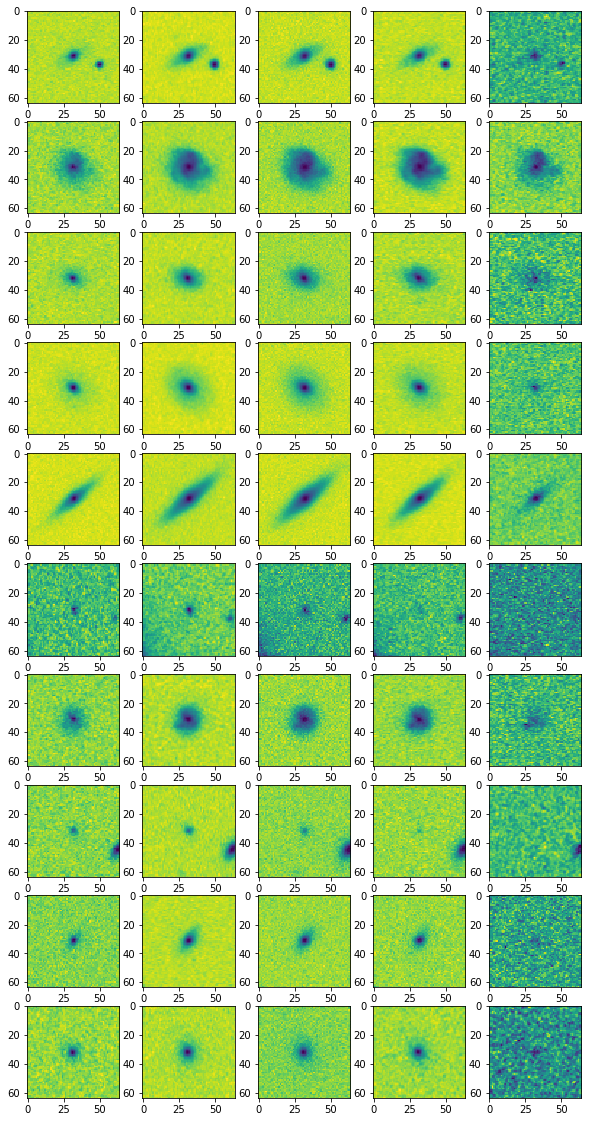

In [11]:
I = 10
plt.figure(figsize=(I, 2*I))

for i in range(I):
    plt.subplot(I,5,1+i*5)
    plt.imshow(Image[i][4])
    plt.subplot(I,5,2+i*5)
    plt.imshow(Image[i][3])
    plt.subplot(I,5,3+i*5)
    plt.imshow(Image[i][2])
    plt.subplot(I,5,4+i*5)
    plt.imshow(Image[i][1])
    plt.subplot(I,5,5+i*5)
    plt.imshow(Image[i][0])

In [94]:
Image_RGB = np.empty((len(Image),64,64))#(14142,64,64,1) one channel images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = Image[i][3]


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*1):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [95]:
Image_RGB.shape

(14142, 64, 64)

In [96]:
#Image_RGB =(1- ( (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))))*2 - 1

Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

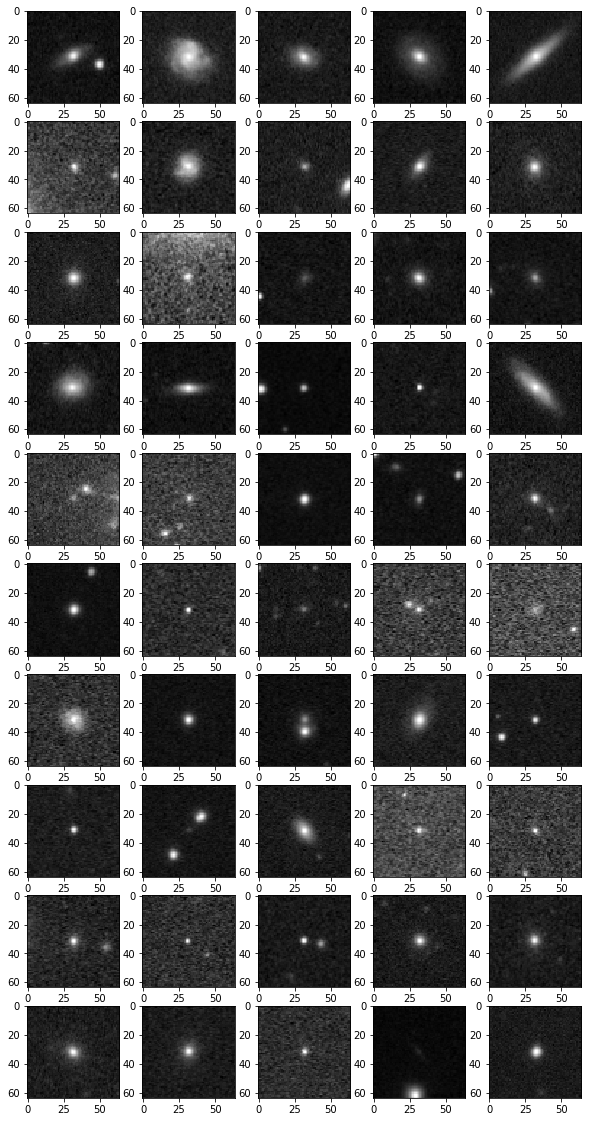

In [97]:
I = 10
plt.figure(figsize=(I, 2*I))

for i in range(I):
    plt.gray()
    plt.subplot(I,5,1+i*5)
    plt.imshow(Image_RGB[i*5+0])
    plt.subplot(I,5,2+i*5)
    plt.imshow(Image_RGB[i*5+1])
    plt.subplot(I,5,3+i*5)
    plt.imshow(Image_RGB[i*5+2])
    plt.subplot(I,5,4+i*5)
    plt.imshow(Image_RGB[i*5+3])
    plt.subplot(I,5,5+i*5)
    plt.imshow(Image_RGB[i*5+4])
    

In [98]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB.reshape(-1,64,64,1)
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
#show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 1)
train_label.shape: (14142, 3)


In [99]:
batch_size =100
latent_dim = 30
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 600
#intermediate_dim_2 = 300
original_dim = 64*64

input_img = Input(shape=(64,64,1))

conv_1 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
#maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(conv_4)
h_1 = Dense(intermediate_dim_1, activation='relu')(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='tanh')(z)
h_5 = Dense(80*8*8,activation='relu')(h_4)
h_6 = Reshape((8,8,80))(h_5)


#conv_6 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(h_6)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_6)
#upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(conv_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  


vae = Model(inputs=input_img, outputs=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)



In [104]:
vae.fit(train_data[:14000], train_data[:14000],
        shuffle=True,
        epochs=20, 
        batch_size=batch_size,
        validation_data=(train_data[14000:14100],train_data[14000:14100]),callbacks=[EarlyStopping])

Train on 14000 samples, validate on 100 samples
Epoch 1/20
14000/14000 [==============================] - 30s - loss: -89.8303 - val_loss: -74.9328
Epoch 2/20
14000/14000 [==============================] - 30s - loss: -90.2032 - val_loss: -75.8303
Epoch 3/20
14000/14000 [==============================] - 30s - loss: -90.3688 - val_loss: -75.9213
Epoch 4/20
14000/14000 [==============================] - 30s - loss: -90.6823 - val_loss: -75.3942
Epoch 5/20
14000/14000 [==============================] - 30s - loss: -90.9382 - val_loss: -72.7743
Epoch 6/20
14000/14000 [==============================] - 30s - loss: -91.0860 - val_loss: -75.9338
Epoch 7/20
14000/14000 [==============================] - 30s - loss: -91.3030 - val_loss: -75.8389
Epoch 8/20
14000/14000 [==============================] - 30s - loss: -91.3664 - val_loss: -76.0407
Epoch 9/20
14000/14000 [==============================] - 30s - loss: -91.4217 - val_loss: -75.4586
Epoch 10/20
14000/14000 [===========================

In [155]:
#vae.save_weights("Correct_normalization_great_segmentation0807.h5")#

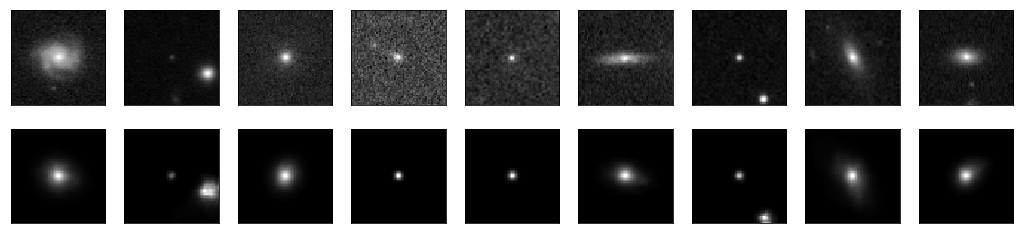

In [105]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = vae.predict(train_data[8000:9500],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9500][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [140]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
#model_pool_4 = Model(input_img,maxpool_4)
#model_conv_5 = Model(input_img,conv_5)
#model_pool_5 = Model(input_img,maxpool_5)
#model_conv_6 = Model(input_img,conv_6)
#model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
#model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
#lyr.append(model_pool_4)
#lyr.append(model_conv_5)
#lyr.append(model_pool_5)
#lyr.append(model_conv_6)
#lyr.append(model_up_6)
lyr.append(model_conv_7)
#lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)
lyr.append(vae)

In [146]:
import scipy
RANGE=20
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in [0,1,2,3,4,5,6,14]:
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

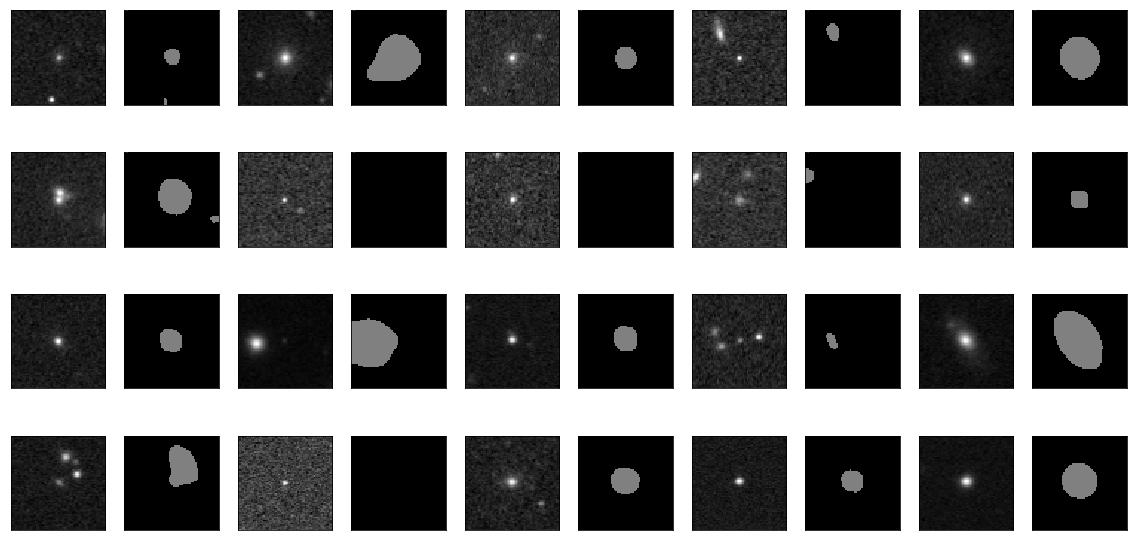

In [147]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
#db = DBSCAN(eps=0.5, min_samples=200).fit(m)
#cluster_labels = db.labels_
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
#SC = SpectralClustering(n_clusters=2).fit(m)
cluster_labels = kmeans.fit_predict(m)

imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 10))
for i in range(RANGE):
    ax = plt.subplot(4,10,i*2+1)
    plt.imshow(Image_RGB[10000:10100][i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set2")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

In [148]:
import scipy
RANGE=20
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in range(np.shape(lyr)[0]-11):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10100:10200],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

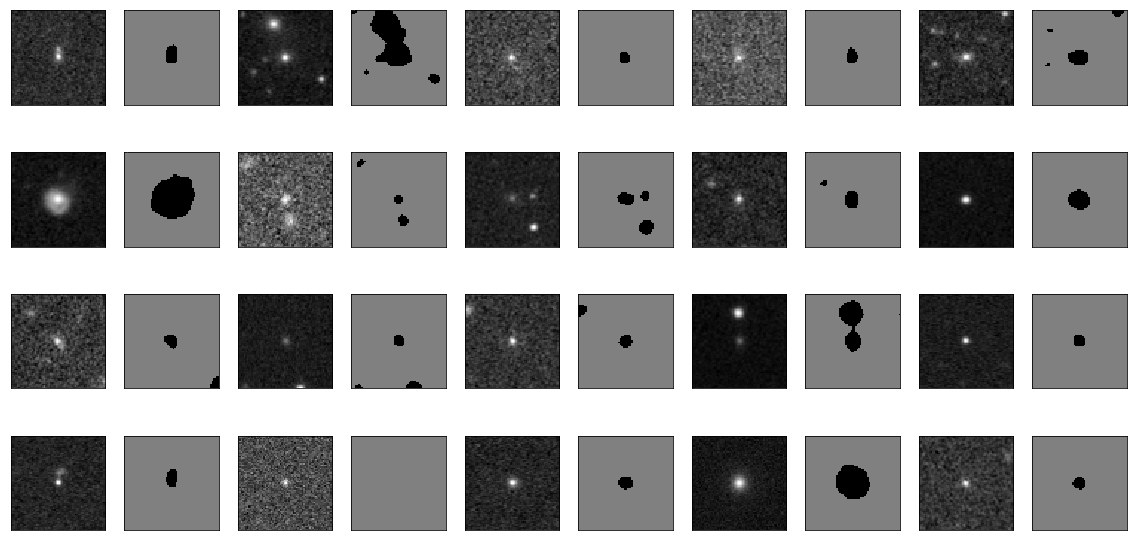

In [149]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
#db = DBSCAN(eps=0.5, min_samples=200).fit(m)
#cluster_labels = db.labels_
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
#SC = SpectralClustering(n_clusters=2).fit(m)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 10))
for i in range(RANGE):
    ax = plt.subplot(4,10,i*2+1)
    plt.imshow(Image_RGB[10100:10200][i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set2")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

In [151]:
import scipy
RANGE=40
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in range(np.shape(lyr)[0]-11):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10200:10300],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

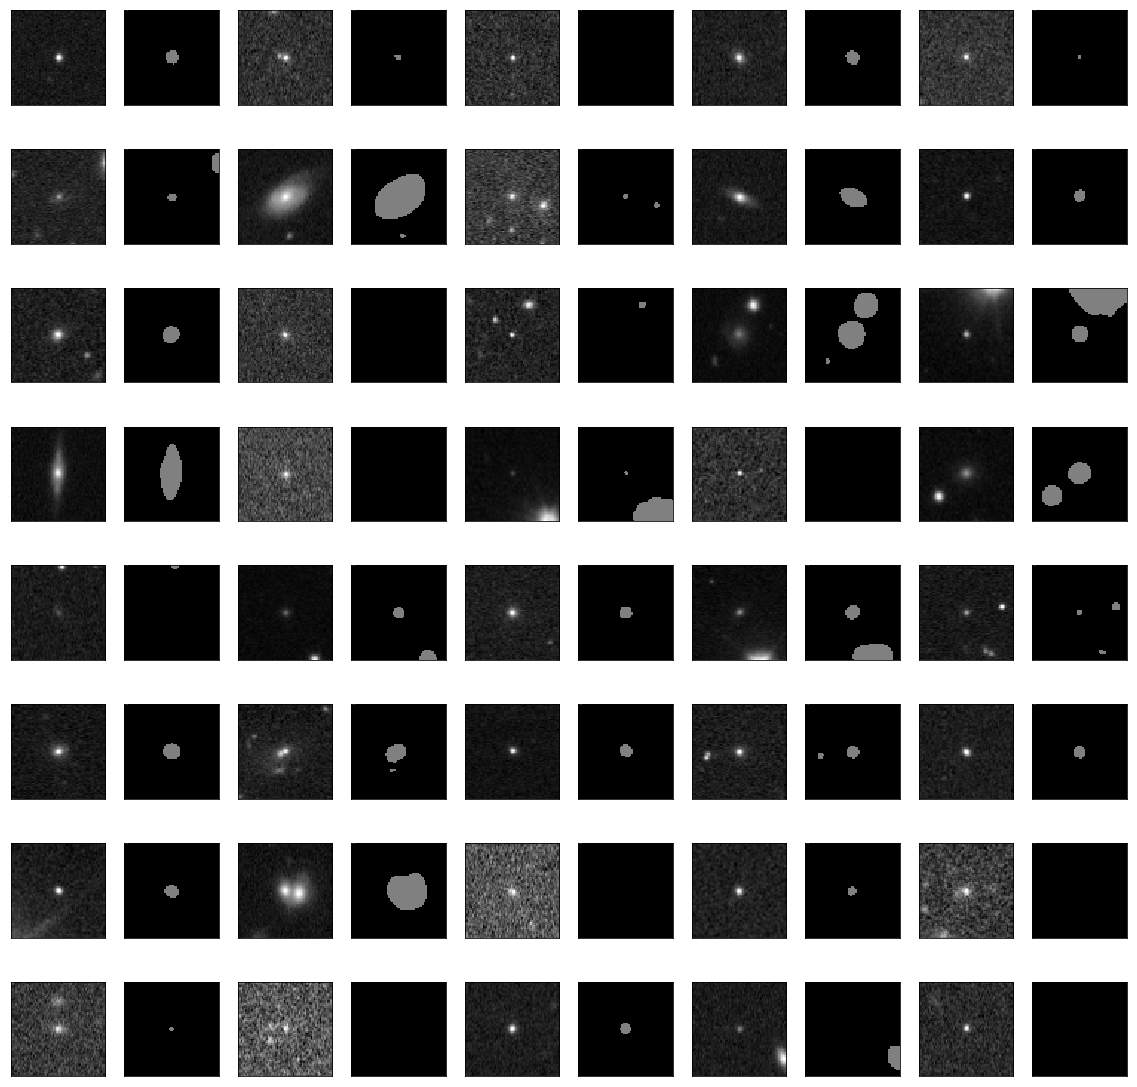

In [153]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
#db = DBSCAN(eps=0.5, min_samples=200).fit(m)
#cluster_labels = db.labels_
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
#SC = SpectralClustering(n_clusters=2).fit(m)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 20))
for i in range(RANGE):
    ax = plt.subplot(8,10,i*2+1)
    plt.imshow(Image_RGB[10200:10300][i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(8,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set2")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

In [107]:
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)

In [108]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

In [124]:
count_ = 0
for i in range(len(x_vis)):
    if Y_pred[8500:14000][i] <0.7:
        count_+=1
print("predict abs with threshold above:\n",count_/len(x_vis))
print(" %.4g" % float(np.sum(Class[Class==1])/14142*100),"%")

predict abs with threshold above:
 0.7050909090909091
 67.85 %


In [125]:
count_gala = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] <0.7):
        if Class[i]==1:
            count_gala+=1
print(count_gala/np.sum(Class[Class==1]))
print(np.sum(Class[Class==1])-count_gala)

0.632555231346
3526


In [126]:
count_star = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] >0.7):
        if Class[i]==0:
            count_star+=1
print(count_star/(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2))
print((len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)

0.17981600223
2942.0


In [120]:
print("total accuracy is:",1-((np.sum(Class[Class==1])-count_gala)+(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)/len(Y_pred))

total accuracy is: 0.63215952482


In [44]:
train_data.shape

(14142, 64, 64, 1)

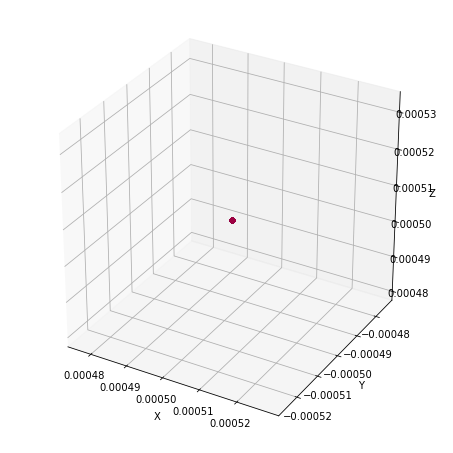

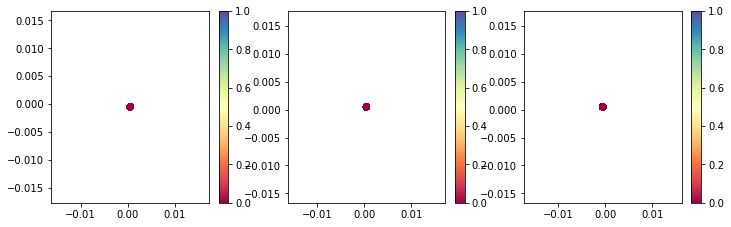

In [46]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
    
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 0] ,x_vis[:, 1], x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

